In [12]:
from torch_tools.m_dataset import MDataset,ch_names 
from torch_tools.train_test import train,test,test_roc
from torch_tools.DOCinformer import DOCinformer
from torch.utils.data import DataLoader
from glob import glob
import torch
from torch.utils.data.dataset import ConcatDataset
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split,KFold
import gc
import pandas as pd
import optuna
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt

In [13]:
t_window = 10
t_overlap = 0.0
sf = 250

In [14]:
n_folds = 5
valid_ratio = 0.2
random_state = 555
ckp_parent_dir = 'ckp\\pdoc\\DOCinformer'

In [15]:
# 读取pdoc
sub_regex = 'F:\\PLL\\静息态数据没有ICA\\*.mat'
sub_paths = glob(sub_regex)

In [16]:
def sub_kfold_withvalid(sub_dataset_list,n_folds,valid_ratio,random_state=0):
    # 分k折
    train_folds={}
    valid_folds={}
    test_folds={}
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    for i, (train_indexes, test_indexes) in enumerate(kf.split(sub_dataset_list)):
        train_subjects = [sub_dataset_list[train_index]  for train_index in train_indexes]
        test_subjects = [sub_dataset_list[test_index]  for test_index in test_indexes]
        # valid
        if valid_ratio == 0:
            valid_subjects = test_subjects
        else:
            train_subjects,valid_subjects = train_test_split(train_subjects,test_size=valid_ratio,shuffle=True,random_state=random_state)
        # 记录本fold的subject编号
        train_folds[i]=train_subjects
        valid_folds[i]=valid_subjects
        test_folds[i]=test_subjects   
    return train_folds,valid_folds,test_folds

In [17]:
def trainnfold(standard_chs,nets,optimizers,batch_size,epochs,ckp_dir):
    if not os.path.exists(ckp_dir):
        os.makedirs(ckp_dir)
    # load
    pdoc_sub_dataset_list = []
    pdoc_label_dict =  {
        'VS':0,
        'MCS':1,
    } 
    for sub_path in sub_paths:
        sub_dataset = MDataset(sub_path,t_window,t_overlap,standard_chs,pdoc_label_dict)
        if len(sub_dataset)>0 :
            pdoc_sub_dataset_list.append(sub_dataset)
    pdoc_train_folds,pdoc_valid_folds,_  = sub_kfold_withvalid(pdoc_sub_dataset_list,n_folds,valid_ratio,random_state)

    avg_test_result = 0.0
    for i in range(n_folds): 
        fold_ckp_path = ckp_dir+'\\'+f'fold_{i}.pth'
        # loader
        train_dataset = ConcatDataset(pdoc_train_folds[i])
        valid_dataset = ConcatDataset(pdoc_valid_folds[i])  
        train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=False)
        valid_loader = DataLoader(valid_dataset,batch_size=batch_size,shuffle=True,drop_last=False)
        # 训练
        net = nets[i]
        optimizer = optimizers[i]
        fold_test_result = train(net,fold_ckp_path,train_loader,valid_loader,optimizer,epochs,use_best_valid = True)
        print(f' finish fold test:{fold_test_result}')
        avg_test_result += fold_test_result
    avg_test_result = avg_test_result/n_folds
    gc.collect()
    return avg_test_result

In [18]:
def testnfold(standard_chs,nets,ckp_dir):
    # load dataset
    pdoc_sub_dataset_list = []
    for sub_path in sub_paths:
        sub_dataset = MDataset(sub_path,t_window,0.0,standard_chs,{'MCS':1})
        if len(sub_dataset)>0 :
            pdoc_sub_dataset_list.append(sub_dataset)
        sub_dataset = MDataset(sub_path,t_window,0.0,standard_chs,{'VS':0})
        if len(sub_dataset)>0 :
            pdoc_sub_dataset_list.append(sub_dataset)
    pdoc_train_folds,pdoc_valid_folds,pdoc_test_folds  = sub_kfold_withvalid(pdoc_sub_dataset_list,n_folds,valid_ratio,random_state)
    
    avg_test_acc = 0.0
    avg_test_precision = 0.0
    avg_test_f1 = 0.0
    avg_test_recall = 0.0

    tprs = []
    roc_aucs = []  
    fold_test_results = []
    for i in range(n_folds):
        fold_ckp_path = ckp_dir+'\\'+f'fold_{i}.pth'
        net = nets[i]
        test_subs = pdoc_test_folds[i]
        # 记录本折测试结果
        fold_test_result = test(net,fold_ckp_path,DataLoader(ConcatDataset(test_subs),batch_size=8,shuffle=True,drop_last=False))
        fold_test_results.append(fold_test_result)
        avg_test_acc += fold_test_result["acc"]
        avg_test_precision += fold_test_result["precision"]
        avg_test_recall += fold_test_result["recall"]
        avg_test_f1 += fold_test_result["f1"]
        # 记录本折ROC结果
        mean_fpr,interp_tpr,roc_auc = test_roc(net,fold_ckp_path,DataLoader(ConcatDataset(test_subs),batch_size=8,shuffle=True,drop_last=False))
        tprs.append(interp_tpr)
        roc_aucs.append(roc_auc)

        
    ## 处理测试结果
    # 最后一行是平均
    avg_test_acc = avg_test_acc/n_folds
    avg_test_precision = avg_test_precision/n_folds
    avg_test_recall = avg_test_recall/n_folds
    avg_test_f1 = avg_test_f1/n_folds
    avg_result = {"precision":avg_test_precision,"recall":avg_test_recall,"f1":avg_test_f1,"acc":avg_test_acc}
    print(avg_result)
    fold_test_results.append(avg_result)
    df = pd.DataFrame(fold_test_results)
    # 保存为CSV文件
    df.to_csv(ckp_dir+f"-use{len(standard_chs)}-test.csv", index=False)

    ## 绘制ROC曲线
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(roc_aucs)
    std_auc = np.std(roc_aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=0.8)
    joblib.dump((mean_tpr,mean_auc),ckp_dir+f"-use{len(standard_chs)}-test.joblib")
    return avg_result,mean_auc

In [19]:
def objective(trial,standard_chs,test=False,part_chs = None):
    ckp_dir = ckp_parent_dir + '\\' + f'ch{len(standard_chs)}-trail{trial.number}'
    # 模型结构参数
    pool_time_stride = trial.suggest_categorical("pool_time_stride", [200])
    n_filters_time = trial.suggest_categorical("n_filters_time", [64])
    filter_time_length = trial.suggest_categorical("filter_time_length", [25])
    depth = trial.suggest_int('depth', 1,1)
    att_heads =  trial.suggest_int('att_heads', 1,1)
    # 训练参数
    epochs = 20
    batch_size = trial.suggest_categorical("batch_size", [16])
    lr = (4*trial.suggest_int('lr',1,1))*1e-4
    wd = trial.suggest_categorical("wd", [0.1])
   # setting
    nets = [DOCinformer(n_outputs=2, input_window_seconds=t_window,sfreq=sf, standard_chs = standard_chs,positionEncoding = 'coordinate',channel_drop_prob = 0.2,att_drop_prob = 0.4,
                                              filter_time_length=filter_time_length,att_depth=depth,att_heads=att_heads,n_filters_time=n_filters_time,pool_time_stride = pool_time_stride,pool_time_length=pool_time_stride)
            for i in range(n_folds)]
    optimizers = [torch.optim.AdamW(net.parameters(), lr=lr,weight_decay=lr*wd)
            for net in nets]
    # t
    if test:
        for net in nets:
            net.select_channel(part_chs)
        return testnfold(part_chs,nets,ckp_dir)
    else:
        return trainnfold(standard_chs,nets,optimizers,batch_size,epochs,ckp_dir)

In [ ]:
# standard_chs = ['Fpz','P8', 'Oz', 'TP9', 'C4', 'FC6', 'F4', 'CP6', 'CP1', 'P4',  
#            'T7', 'FC1', 'O1', 'TP10', 'FC2', 'CP2', 'C3', 'P7', 'FC5', 'F7', 
#            'P3', 'Fp2', 'O2', 'F8', 'Pz', 'CP5','F3', 'Fp1', 'T8','Fz']
# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: objective(trial,standard_chs), n_trials=10)
# joblib.dump(study.best_trial, ckp_parent_dir+"//best_trail.joblib")

In [21]:
best_trial = joblib.load(ckp_parent_dir+"//best_trail.joblib")

precision:0.6458333333333334,recall:0.9232531500572738,f1:0.7600188590287601,acc:0.6696950032446464
precision:0.7549450549450549,recall:0.8439803439803439,f1:0.796983758700696,acc:0.7571131158917418
precision:0.9155080213903743,recall:0.9617977528089887,f1:0.9380821917808219,acc:0.904480135249366
precision:0.8058091286307054,recall:0.9345524542829644,f1:0.8654188948306596,acc:0.8007915567282322
precision:0.8531073446327684,recall:0.8154815481548154,f1:0.8338702254947078,acc:0.7410329985652798
{'precision': 0.7950405765864472, 'recall': 0.895813049856877, 'f1': 0.838874785967129, 'acc': 0.7746225619358532}


({'precision': 0.7950405765864472,
  'recall': 0.895813049856877,
  'f1': 0.838874785967129,
  'acc': 0.7746225619358532},
 0.7560074289283094)

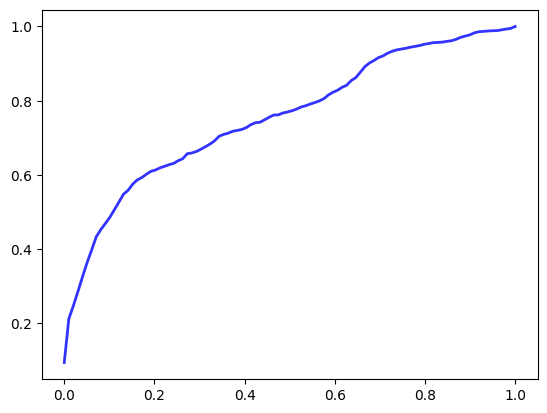

In [22]:
standard_chs = ['Fpz','P8', 'Oz', 'TP9', 'C4', 'FC6', 'F4', 'CP6', 'CP1', 'P4',  
           'T7', 'FC1', 'O1', 'TP10', 'FC2', 'CP2', 'C3', 'P7', 'FC5', 'F7', 
           'P3', 'Fp2', 'O2', 'F8', 'Pz', 'CP5', 'F3', 'Fp1', 'T8','Fz']
objective(best_trial,standard_chs,True,standard_chs)

precision:0.5903780068728522,recall:0.983963344788087,f1:0.7379725085910653,acc:0.6041531473069436
precision:0.728042328042328,recall:0.8452088452088452,f1:0.7822626492325184,acc:0.7342123525329632
precision:0.8311195445920304,recall:0.9842696629213483,f1:0.9012345679012347,acc:0.8377007607776839
precision:0.7876175548589341,recall:0.9672762271414822,f1:0.8682505399568035,acc:0.7988126649076517
precision:0.8126843657817109,recall:0.991899189918992,f1:0.8933927847588164,acc:0.8113342898134863
{'precision': 0.7499683600295711, 'recall': 0.9545234539957509, 'f1': 0.8366226100880876, 'acc': 0.7572426430677458}


({'precision': 0.7499683600295711,
  'recall': 0.9545234539957509,
  'f1': 0.8366226100880876,
  'acc': 0.7572426430677458},
 0.7454392732658162)

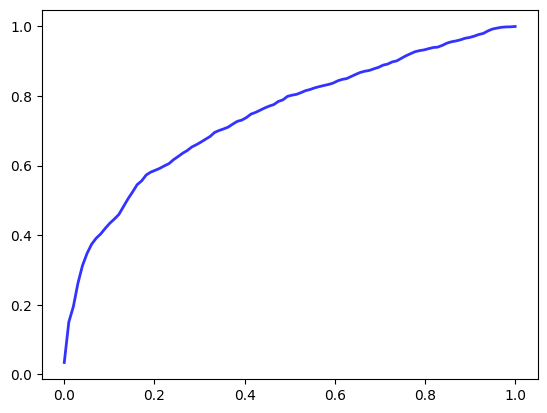

In [23]:
f_chs =  ['Fp1','Fp2','Fpz','F3','F4','F7','F8','Fz']
objective(best_trial,standard_chs,True,f_chs)